In [1]:
import os, math
from collections import defaultdict, namedtuple, deque
import dataclasses
from dataclasses import dataclass
import itertools
from enum import StrEnum, auto
import sqlite3
import logging
import logging.handlers
import pickle
import datetime
import multiprocessing as mp

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from module.utils import *
from module.hdc import *
from module.constants import *

In [2]:
LOG = Logging()

config_var = 'SQLITE3_SEQ_GRID_0_2_4096'
config = Config(config_var)
RNG = np.random.default_rng()
mp_ctx = mp.get_context('spawn') # req-d for CUPY to work, fork method leads to failures in bootstrap somewhere around CUDA

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
    xp_array_to_gpu_copy = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    xp_array_to_gpu_copy = lambda a: a.copy()

print(f'xp = {xp.__name__}')

hdc = Hdc(10_000, xp)

xp = numpy


In [3]:
%run sequencing_sp2.ipynb

# Open DB

In [4]:
%time
train_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.train_db_file_name))
test_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.test_db_file_name))
test_results_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.test_results_db_file_name, with_prefix=False), autocommit=True)

if not DBUtils.is_table_exists(test_results_db_con, 'test_runs'):
    test_results_db_con.execute('CREATE TABLE test_runs(test_run_id INTEGER PRIMARY KEY, dummy)')

df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 4.05 μs


((100, 9), (20, 9))


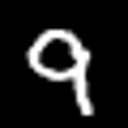
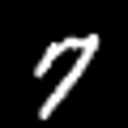
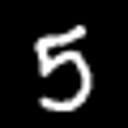
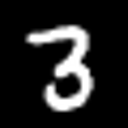
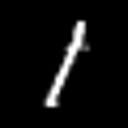
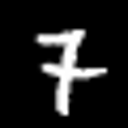
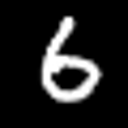
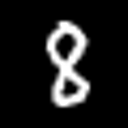
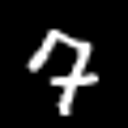
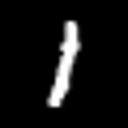
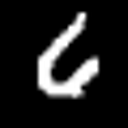
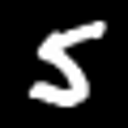
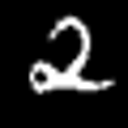
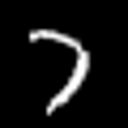
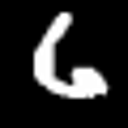
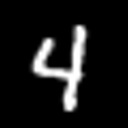

In [5]:
count = 8

def get_images_and_labels(df, ids):
    image_datas = df.loc[ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[ids]['value']
    return images, list(labels)

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    return get_images_and_labels(df, image_ids)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

# Core logic

## Types

In [6]:
SeqLatentVecMeta = namedtuple('SeqLatentVec', ['engram_id', 'phase', 'seq', 'seq_lv_ind'])
Engram = namedtuple('Engram', ['engram_id', 'image_id', 'value', 'seq_lv_inds', 'si_ind_dict'])
Matchee = namedtuple('Matchee', ['seqs', 'seq_lvs', 'seq_lv_codes', 'si_ind_dict'])

## memory

In [7]:
SEQ_LV_LEN = 1000
SEQ_LVS = HdvArray(SEQ_LV_LEN * 2, xp)
SEQ_LV_IND_TO_META = {} # key - index in SEQ_LVS, value - SeqLatentVecMeta
ENGRAMS = {} # key - engram id, value - engram instance
ENGRAM_ID_SOURCE = itertools.count(1)

In [8]:
def clear_memory():
    SEQ_LVS.clear()
    SEQ_LV_IND_TO_META.clear()
    ENGRAMS.clear()

## lambdas

In [9]:
expand_normal_vec = lambda j: (j.real, j.imag)
fetch_si_xy = lambda si: (si.x, si.y)
get_sequence = lambda sequences: np.array(list(itertools.chain.from_iterable(sequences)))
get_normal_sequence = lambda sequence, si_ind_dict: np.array(list(map(lambda si_ind: expand_normal_vec(si_ind_dict[si_ind].normal_vec), sequence)))
get_xy_sequence = lambda sequence, si_ind_dict: np.array(list(map(lambda si_ind: fetch_si_xy(si_ind_dict[si_ind]), sequence)))

## render_image

In [10]:
def render_image(image_id, df_images, image_sz=(600, 600)):
    df_image = df_images.loc[image_id]
    image_png = df_image['png']
    image = Image.open(io.BytesIO(image_png))
    image = image.convert('RGB')
    k = image.size[0]
    image = image.resize(image_sz)
    k = image.size[0] / k
    image_draw = ImageDraw.Draw(image)

    inner_si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
    inner_sequences = pickle.loads(df_image['inner_sequences'])
        
    for seq in inner_sequences:
        for si_ind_from, si_ind_to in zip(seq, seq[1:]):
            si_from = inner_si_ind_dict[si_ind_from]
            si_to = inner_si_ind_dict[si_ind_to]
            pt_from = si_from.x * k, si_from.y * k
            pt_to = si_to.x * k, si_to.y * k
            image_draw.line([pt_from[0], pt_from[1], pt_to[0], pt_to[1]], width=1, fill='red')
            
            nl = 6 * k
            image_draw.rectangle([pt_from[0]-1, pt_from[1]-1, pt_from[0]+1, pt_from[1]+1], outline='red')
            normal_vec = si_from.normal_vec
            image_draw.line([pt_from[0], pt_from[1], pt_from[0] + normal_vec.real * nl, pt_from[1] + normal_vec.imag * nl], width=1, fill='red')
            image_draw.text([pt_from[0] + normal_vec.real * nl*1.2, pt_from[1] + normal_vec.imag * nl*1.2], str(si_ind_from), anchor='mm', fill='red')

            image_draw.rectangle([pt_to[0]-1, pt_to[1]-1, pt_to[0]+1, pt_to[1]+1], outline='red')
            normal_vec = si_to.normal_vec
            image_draw.line([pt_to[0], pt_to[1], pt_to[0] + normal_vec.real * nl, pt_to[1] + normal_vec.imag * nl], width=1, fill='red')
            image_draw.text([pt_to[0] + normal_vec.real * nl*1.2, pt_to[1] + normal_vec.imag * nl*1.2], str(si_ind_to), anchor='mm', fill='red')

    return image

## calc_seq_latent_vector

In [11]:
def calc_seq_latent_vector(sequence, si_ind_dict):
    xy_sequence = get_xy_sequence(sequence, si_ind_dict)
    vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
                                     zip(xy_sequence, np.vstack([xy_sequence[1:], xy_sequence[:1]])))))
    vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
    vec_len_sequence = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
    norm_vec_sequence = (vec_sequence.T / vec_len_sequence).T
    
    assert sequence.shape[0] == vec_sequence.shape[0]
    assert sequence.shape[0] == vec_len_sequence.shape[0]
    assert sequence.shape[0] == norm_vec_sequence.shape[0]

    seq_len = vec_len_sequence.sum()
    # seq_lv = np.zeros(SEQ_LV_LEN * 2, dtype='F')
    seq_lv = np.zeros((SEQ_LV_LEN, 2))
    assert seq_len <= seq_lv.shape[0] # TODO: weak point if e.g. there is only one but very long sequence, think about it
    k = seq_lv.shape[0] / seq_len
    si_ind_to_phase = {}
    
    i = 0
    i_from = 0
    
    for j, (si_ind, norm_vec, vec_len) in enumerate(zip(sequence, norm_vec_sequence, vec_len_sequence)):
        if vec_len > 0:
            i += vec_len
            i_to = min(int(i * k), seq_lv.shape[0])
            assert i_from >= 0, i_from
            assert i_to >= i_from, (i_to, i_from)
            assert i_to <= seq_lv.shape[0], (i_to, seq_lv.shape[0])
            #norm_vec_j = complex(norm_vec[0], norm_vec[1])
        
            if si_ind == sequence[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
                # seq_lv[i_from:] = norm_vec_j
                seq_lv[i_from:] = norm_vec
            else:
                # seq_lv[i_from:i_to] = norm_vec_j
                seq_lv[i_from:i_to] = norm_vec
    
        # si_ind_to_phase[si_ind] = i_from
        si_ind_to_phase[si_ind] = i_from * 2
        
        if i_to >= seq_lv.shape[0]:
            # Sometimes we may get si_inds with equal (x, y). This is due to resolution issues from hires to lores
            # (i.e. (x2, y2) for such si actually differ). 
            assert ((si_ind == sequence[-1]) or (all(map(lambda l: l == 0, vec_len_sequence[j+1:])))) , (si_ind, sequence[-1])
            break
    
        i_from = i_to

    return seq_lv.ravel(), si_ind_to_phase

## create_engram

In [12]:
def create_engram(df_image):
    image_id = int(df_image.name)
    si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
    sequences = pickle.loads(df_image['inner_sequences'])
    sequence = get_sequence(sequences) # assembly of default sequence
    seq_lv, si_ind_to_phase = calc_seq_latent_vector(sequence, si_ind_dict)
    engram_id = next(ENGRAM_ID_SOURCE)
    seq_lv_inds = []
    
    # Phasing (for sequences near to circular) + persisting
    for i, si_ind in enumerate(sequence):
        phase = si_ind_to_phase[si_ind]
        phased_seq = np.roll(sequence, -i, axis=0)
        phased_seq_lv = np.roll(seq_lv, -phase, axis=0)
        seq_lv_ind = SEQ_LVS.lease()
        SEQ_LVS.array_active[seq_lv_ind] = phased_seq_lv
        seq_lv_meta = SeqLatentVecMeta(engram_id=engram_id, phase=phase, seq=phased_seq, seq_lv_ind=seq_lv_ind)
        SEQ_LV_IND_TO_META[seq_lv_ind] = seq_lv_meta
        seq_lv_inds.append(seq_lv_ind)
        
    return Engram(engram_id=engram_id, image_id=int(image_id), value=df_image['value'], seq_lv_inds=seq_lv_inds, si_ind_dict=si_ind_dict)

## create_matchee

In [13]:
def create_matchee(df_image, seq_lv_code=None):
    si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
    sequences = pickle.loads(df_image['inner_sequences'])
    matchee = Matchee(seqs=[], seq_lvs=[], seq_lv_codes=[], si_ind_dict=si_ind_dict)
    
    # Take up to 5 sequences. More than 5 explodes too fast. Close to Miller's number (https://en.wikipedia.org/wiki/The_Magical_Number_Seven,_Plus_or_Minus_Two)
    # Count of variants = (seqs_count)! * 2^seqs_count
    # seqs_count | variant_counts
    # ______________________
    # 1          | 2
    # 2          | 8
    # 3          | 42
    # 4          | 384
    # 5          | 3840
    # 6          | 46080
    # 7          | 645120
    
    MAX_SEQUENCES_COUNT = 5

    if len(sequences) > MAX_SEQUENCES_COUNT:
        seq_indices = RNG.choice(len(sequences), MAX_SEQUENCES_COUNT, replace=False)
        # TODO: another implementation may be to take up to 4 sequences and all remaining as combined
    else:
        seq_indices = list(range(len(sequences)))
        
    assert len(seq_indices) <= MAX_SEQUENCES_COUNT

    if seq_lv_code is None:
        for perm_seq_indices in itertools.permutations(seq_indices, len(seq_indices)):
            for seq_orientation in itertools.product(range(2), repeat=len(seq_indices)):
                matchee.seq_lv_codes.append(tuple(zip(perm_seq_indices, seq_orientation)))
    else:
        matchee.seq_lv_codes.append(seq_lv_code)
    
    for seq_lv_code in matchee.seq_lv_codes:
        maps = map(lambda seq_ind_and_orient: sequences[seq_ind_and_orient[0]] if seq_ind_and_orient[1] == 0 else reversed(sequences[seq_ind_and_orient[0]]), seq_lv_code)
        sequence = np.array(list(itertools.chain.from_iterable(maps)))
        seq_lv, _ = calc_seq_latent_vector(sequence, si_ind_dict)
        matchee.seqs.append(sequence)
        matchee.seq_lvs.append(seq_lv)

    return matchee._replace(seq_lvs=np.array(matchee.seq_lvs))

## get_match_tab

In [14]:
def compute_seq_lvs_diff(engram_seq_lv, matchee_seq_lv):
    engram_seq_lv_j = engram_seq_lv.reshape(-1, 2)
    engram_seq_lv_j = engram_seq_lv_j[:,0] + 1j * engram_seq_lv_j[:,1]
    matchee_seq_lv_j = matchee_seq_lv.reshape(-1, 2)
    matchee_seq_lv_j = matchee_seq_lv_j[:,0] + 1j * matchee_seq_lv_j[:,1]
    return np.sum(np.absolute(engram_seq_lv_j - matchee_seq_lv_j))

In [15]:
def get_match_tab(matchee, compute_diff=False, inspect_depth=100):
    match_tab_columns = defaultdict(list)
    cos_sims_mat = (SEQ_LVS.array_active @ matchee.seq_lvs.T) / SEQ_LV_LEN # TODO: division can be omitted actually
    top_cos_sim_indices = np.argsort(cos_sims_mat, axis=None)[-inspect_depth:] 
    
    for cos_sim_index in reversed(top_cos_sim_indices):
        i = cos_sim_index // cos_sims_mat.shape[1]
        j = cos_sim_index % cos_sims_mat.shape[1]
        seq_lv_meta = SEQ_LV_IND_TO_META[i]
        engram = ENGRAMS[seq_lv_meta.engram_id]

        if compute_diff:
            engram_seq_lv = SEQ_LVS.array_active[i]
            matchee_seq_lv = matchee.seq_lvs[j]
            diff = compute_seq_lvs_diff(engram_seq_lv, matchee_seq_lv)
        else:
            diff = -1
            
        match_tab_columns['engram_seq_lv_ind'].append(i)
        match_tab_columns['matchee_seq_lv_ind'].append(j)
        match_tab_columns['cos_sim'].append(cos_sims_mat[i,j])
        match_tab_columns['diff'].append(diff)  
        match_tab_columns['engram_id'].append(engram.engram_id)
        match_tab_columns['engram_value'].append(engram.value)
        match_tab_columns['engram_image_id'].append(engram.image_id)  
        match_tab_columns['engram_phase'].append(seq_lv_meta.phase)
        match_tab_columns['matchee_seq_lv_code'].append(matchee.seq_lv_codes[j])
    
    return pd.DataFrame(match_tab_columns)

## render_match_tab_row

In [16]:
def render_match_tab_row(df_match_tab_row, matchee):
    image_pil = Image.new('L', size=(800, 800), color='black')
    image_pil = image_pil.convert('RGB')
    k = image_pil.size[0] / config.sample_size
    draw = ImageDraw.Draw(image_pil)
    
    matchee_seq_lv_code = df_match_tab_row['matchee_seq_lv_code']
    matchee_seq_lv_ind = matchee.seq_lv_codes.index(matchee_seq_lv_code)
    matchee_seq = matchee.seqs[matchee_seq_lv_ind]
    matchee_xy_seq = get_xy_sequence(matchee_seq, matchee.si_ind_dict)
    matchee_pt_xy = matchee_xy_seq[0]
    
    engram = ENGRAMS[df_match_tab_row['engram_id']]
    engram_seq_lv_ind = df_match_tab_row['engram_seq_lv_ind']
    engram_seq_lv_meta = SEQ_LV_IND_TO_META[engram_seq_lv_ind]
    engram_seq = engram_seq_lv_meta.seq
    engram_xy_seq = get_xy_sequence(engram_seq, engram.si_ind_dict)
    
    assert engram_seq.shape[0] == engram_xy_seq.shape[0]
    
    engram_xy_seq = engram_xy_seq - engram_xy_seq[0] + matchee_pt_xy
    engram_si_serial_to_xy = {}
    
    for si_serial, (xy_seq_row, seq_row) in enumerate(zip(zip(engram_xy_seq, engram_xy_seq[1:]), zip(engram_seq, engram_seq[1:]))):
        pt_from = xy_seq_row[0][0], xy_seq_row[0][1] 
        pt_to = xy_seq_row[1][0], xy_seq_row[1][1]
        
        vec = pt_to[0] - pt_from[0], pt_to[1] - pt_from[1]
    
        if np.linalg.norm(vec) < 10:
            draw.line([k * pt_from[0], k * pt_from[1], k * pt_to[0], k * pt_to[1]], width=2, fill='red')
            
        draw.rectangle([k * pt_from[0] - 4, k * pt_from[1] - 4, k * pt_from[0] + 4, k * pt_from[1] + 4], width=1, fill='red')
        draw.rectangle([k * pt_to[0] - 4, k * pt_to[1] - 4, k * pt_to[0] + 4, k * pt_to[1] + 4], width=1, fill='red')
    
        si_from = engram.si_ind_dict[seq_row[0]]
        si_to = engram.si_ind_dict[seq_row[1]]
        nl = 4 * k
        normal_vec = si_from.normal_vec
        draw.line([k * pt_from[0], k * pt_from[1], k * pt_from[0] + normal_vec.real * nl, k * pt_from[1] + normal_vec.imag * nl], width=1, fill='darkred')
        draw.text([k * pt_from[0] + normal_vec.real * nl*1.2, k * pt_from[1] + normal_vec.imag * nl*1.2], str(si_serial), anchor='mm', fill='darkred')
    
        normal_vec = si_to.normal_vec
        draw.line([k * pt_to[0], k * pt_to[1], k * pt_to[0] + normal_vec.real * nl, k * pt_to[1] + normal_vec.imag * nl], width=1, fill='darkred')
        # draw.text([pt_to[0] + normal_vec.real * nl*1.2, pt_to[1] + normal_vec.imag * nl*1.2], str(si_ind_to), anchor='mm', fill='red')
        
        engram_si_serial_to_xy[si_serial] = (k * pt_from[0], k * pt_from[1])
        engram_si_serial_to_xy[si_serial + 1] = (k * pt_to[0], k * pt_to[1])
    
    matchee_si_serial_to_xy = {}
    
    for si_serial, (xy_seq_row, seq_row) in enumerate(zip(zip(matchee_xy_seq, matchee_xy_seq[1:]), zip(matchee_seq, matchee_seq[1:]))):
        pt_from = xy_seq_row[0][0], xy_seq_row[0][1] 
        pt_to = xy_seq_row[1][0], xy_seq_row[1][1]
        vec = pt_to[0] - pt_from[0], pt_to[1] - pt_from[1]
    
        if np.linalg.norm(vec) < 10:
            draw.line([k * pt_from[0], k * pt_from[1], k * pt_to[0], k * pt_to[1]], width=2, fill='green')
            
        draw.rectangle([k * pt_from[0] - 4, k * pt_from[1] - 4, k * pt_from[0] + 4, k * pt_from[1] + 4], width=1, fill='green')
        draw.rectangle([k * pt_to[0] - 4, k * pt_to[1] - 4, k * pt_to[0] + 4, k * pt_to[1] + 4], width=1, fill='green')
    
        si_from = matchee.si_ind_dict[seq_row[0]]
        si_to = matchee.si_ind_dict[seq_row[1]]
        nl = 4 * k
        normal_vec = si_from.normal_vec
        draw.line([k * pt_from[0], k * pt_from[1], k * pt_from[0] + normal_vec.real * nl, k * pt_from[1] + normal_vec.imag * nl], width=1, fill='darkgreen')
        draw.text([k * pt_from[0] + normal_vec.real * nl*1.2, k * pt_from[1] + normal_vec.imag * nl*1.2], str(si_serial), anchor='mm', fill='darkgreen')
    
        normal_vec = si_to.normal_vec
        draw.line([k * pt_to[0], k * pt_to[1], k * pt_to[0] + normal_vec.real * nl, k * pt_to[1] + normal_vec.imag * nl], width=1, fill='darkgreen')
        # draw.text([pt_to[0] + normal_vec.real * nl*1.2, pt_to[1] + normal_vec.imag * nl*1.2], str(si_ind_to), anchor='mm', fill='red')
        
        matchee_si_serial_to_xy[si_serial] = (k * pt_from[0], k * pt_from[1])
        matchee_si_serial_to_xy[si_serial + 1] = (k * pt_to[0], k * pt_to[1])
    
    draw.circle((k * matchee_pt_xy[0], k * matchee_pt_xy[1]), radius=k*2, outline='blue', width=3)

    seq_lvs_diff = df_match_tab_row['diff']

    if seq_lvs_diff < 0:
        engram_seq_lv = SEQ_LVS.array_active[engram_seq_lv_ind]
        matchee_seq_lv = matchee.seq_lvs[matchee_seq_lv_ind]
        seq_lvs_diff = compute_seq_lvs_diff(engram_seq_lv, matchee_seq_lv)
    
    draw.text((image_pil.size[0] / 2, 10), f'match_tab #{df_match_tab_row.name}, cos_sim={df_match_tab_row['cos_sim']:.2f}, angle={np.rad2deg(np.arccos(df_match_tab_row['cos_sim'])):.0f}, diff={seq_lvs_diff:.0f}', font_size=24, anchor='mt')
    return image_pil

## .lab

In [17]:
# %%time
image_ids = RNG.choice(df_train_images.index, 8, replace=False)
images = list(map(lambda image_id: Image.open(io.BytesIO(df_train_images.loc[image_id]['png'])), image_ids))
captions = [f'{image_ids[0]}']

engram_image_id = image_ids[0]
matchee_image_ids = image_ids[1:]
matchee_image_id = matchee_image_ids[0]
# matchee_image_id = 5941

###
df_image = df_train_images.loc[engram_image_id]
#
si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
sequences = pickle.loads(df_image['inner_sequences'])

engram_id = next(ENGRAM_ID_SOURCE)
engram = Engram(engram_id=engram_id, image_id=int(engram_image_id), value=df_image['value'], seq_lv_inds=[], si_ind_dict=si_ind_dict)

sequence = get_sequence(sequences) # assembly of default sequence
seq_lv, si_ind_to_phase = calc_seq_latent_vector(sequence, si_ind_dict)

# Phasing (for sequences near to circular) + persisting
for si_ind, phase in si_ind_to_phase.items():
    phased_seq_lv = np.roll(seq_lv, -phase, axis=0)
    seq_lv_ind = SEQ_LVS.lease()
    SEQ_LVS.array_active[seq_lv_ind] = phased_seq_lv
    seq_lv_meta = SeqLatentVecMeta(engram_id=engram_id, phase=phase, seq=None, seq_lv_ind=seq_lv_ind)
    SEQ_LV_IND_TO_META[seq_lv_ind] = seq_lv_meta
    engram.seq_lv_inds.append(seq_lv_ind)
    
### 

###
df_image = df_train_images.loc[matchee_image_id]
#
si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
sequences = pickle.loads(df_image['inner_sequences'])
matchee = Matchee(seqs=[], seq_lvs=[], seq_lv_codes=[], si_ind_dict=si_ind_dict)

# Take up to 5 sequences. More than 5 explodes too fast. Close to Miller's number (https://en.wikipedia.org/wiki/The_Magical_Number_Seven,_Plus_or_Minus_Two)
# Count of variants = (seqs_count)! * 2^seqs_count
# seqs_count | variant_counts
# ______________________
# 1          | 2
# 2          | 8
# 3          | 42
# 4          | 384
# 5          | 3840
# 6          | 46080
# 7          | 645120

MAX_SEQUENCES_COUNT = 5

if len(sequences) > MAX_SEQUENCES_COUNT:
    seq_indices = RNG.choice(len(sequences), MAX_SEQUENCES_COUNT, replace=False)
    # TODO: another implementation may be to take up to 4 sequences and all remaining as combined
else:
    seq_indices = list(range(len(sequences)))
    
assert len(seq_indices) <= MAX_SEQUENCES_COUNT

seq_lv_codes = []

for perm_seq_indices in itertools.permutations(seq_indices, len(seq_indices)):
    for seq_orientation in itertools.product(range(2), repeat=len(seq_indices)):
        seq_lv_codes.append(list(zip(perm_seq_indices, seq_orientation)))

for seq_lv_code in seq_lv_codes:
    maps = map(lambda seq_ind_and_orient: sequences[seq_ind_and_orient[0]] if seq_ind_and_orient[1] == 0 else reversed(sequences[seq_ind_and_orient[0]]), seq_lv_code)
    sequence = np.array(list(itertools.chain.from_iterable(maps)))
    seq_lv, _ = calc_seq_latent_vector(sequence, si_ind_dict)
    matchee.seq_lvs.append(seq_lv)

matchee = matchee._replace(seq_lvs=np.array(matchee.seq_lvs))

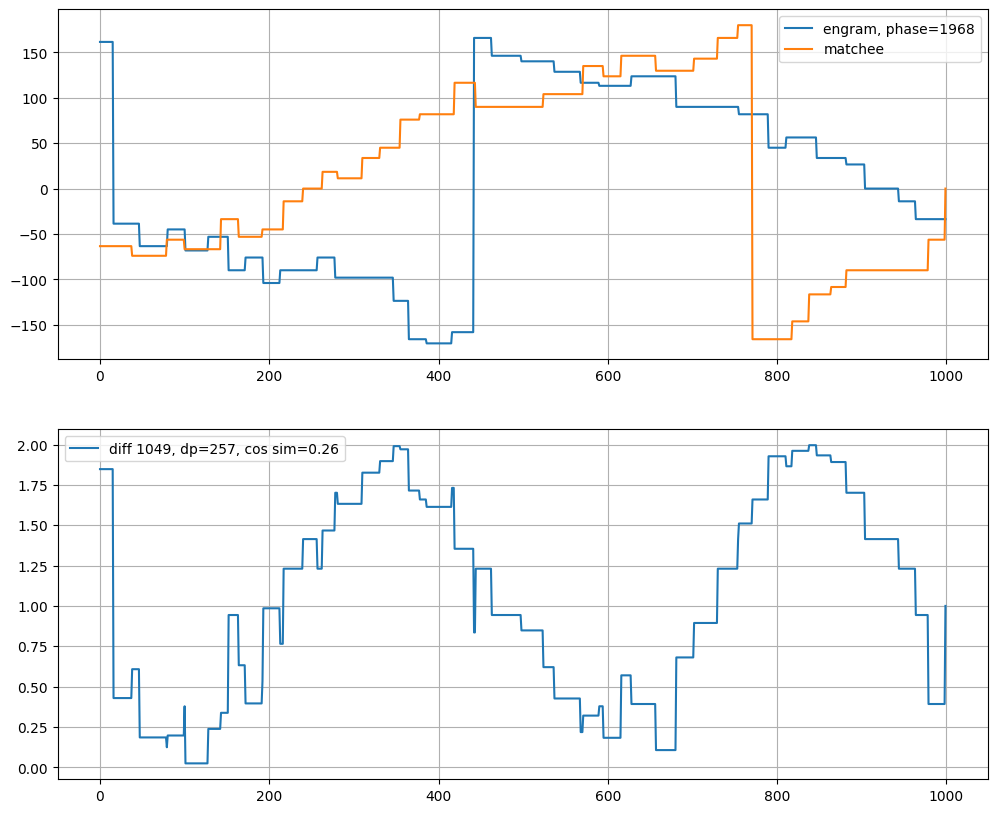

In [18]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)

engram_seq_lv, engram_seq_lv_j = None, None
matchee_seq_lv, matchee_seq_lv_j = None, None

for seq_lv_ind in RNG.choice(engram.seq_lv_inds, 1, replace=False):
    engram_seq_lv = SEQ_LVS.array_active[seq_lv_ind]
    engram_seq_lv_j = engram_seq_lv.reshape(-1, 2)
    engram_seq_lv_j = engram_seq_lv_j[:,0] + 1j * engram_seq_lv_j[:,1]
    plt.plot(np.angle(engram_seq_lv_j, deg=True), label=f'engram, phase={SEQ_LV_IND_TO_META[seq_lv_ind].phase}')

for seq_lv_ind in RNG.choice(matchee.seq_lvs.shape[0], 1, replace=False):
    matchee_seq_lv = matchee.seq_lvs[seq_lv_ind]
    matchee_seq_lv_j = matchee_seq_lv.reshape(-1, 2)
    matchee_seq_lv_j = matchee_seq_lv_j[:,0] + 1j * matchee_seq_lv_j[:,1]
    plt.plot(np.angle(matchee_seq_lv_j, deg=True), label=f'matchee')

plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
diff = np.sum(np.absolute(engram_seq_lv_j - matchee_seq_lv_j))
dp = engram_seq_lv @ matchee_seq_lv
plt.plot(np.absolute(engram_seq_lv_j - matchee_seq_lv_j), label=f'diff {diff:.0f}, dp={dp:0.0f}, cos sim={dp / SEQ_LV_LEN:.2f}')
plt.grid()
plt.legend()

plt.show()

# Train

In [19]:
TRAIN_RUNS_COUNT = 0
TRAIN_IMAGES_COUNT = 0
clear_memory()

In [20]:
# %%time
train_runs = 1
count = min(1000, len(df_train_images))

for _ in tqdm(range(train_runs)):
    TRAIN_RUNS_COUNT += 1
    image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)
    # image_ids = [21514]
    # image_ids = [21613]
    # image_ids = image_ids[0:1]

    for image_id in tqdm(image_ids, leave=False):
        TRAIN_IMAGES_COUNT += 1
        df_image = df_train_images.loc[image_id]
        image_value = df_image['value']
        matchee = create_matchee(df_image)
        df_match_tab = get_match_tab(matchee)
        
        if len(df_match_tab) > 0:
            if df_match_tab.iloc[0]['engram_value'] == image_value:
                continue

        engram = create_engram(df_image)
        ENGRAMS[engram.engram_id] = engram
        print(f'New engram for {image_id:5} {image_value} {len(ENGRAMS)}')

    print(f'Total engrams {len(ENGRAMS)}')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

New engram for 37352 9 1
New engram for 50992 7 2
New engram for 53171 7 3
New engram for 52451 1 4
New engram for 12981 3 5
New engram for  4302 5 6
New engram for 18690 8 7
New engram for 49409 2 8
New engram for  5366 4 9
New engram for 21321 1 10
New engram for  6686 7 11
New engram for 29322 9 12
New engram for 20448 2 13
New engram for 59899 9 14
New engram for 41232 7 15
New engram for 35135 9 16
New engram for  8649 5 17
New engram for  5654 6 18
New engram for 45849 8 19
New engram for  3512 8 20
New engram for 33578 0 21
New engram for 28039 6 22
New engram for 50671 3 23
New engram for 25260 4 24
New engram for 47569 4 25
New engram for 59340 8 26
New engram for 39361 4 27
New engram for 27536 6 28
New engram for 52188 2 29
New engram for 18702 6 30
New engram for  9294 3 31
New engram for  2805 8 32
New engram for  7271 0 33
New engram for 29345 0 34
New engram for 33812 6 35
New engram for 38137 9 36
New engram for 35136 4 37
New engram for  7965 4 38
New engram for 55218 

## .lab

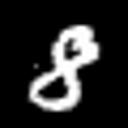

In [21]:
# %%time
image_id = RNG.choice(df_train_images.index)
image = Image.open(io.BytesIO(df_train_images.loc[image_id]['png']))
matchee = create_matchee(df_train_images.loc[image_id])
image

In [22]:
%%time
cos_sims_mat = (SEQ_LVS.array_active @ matchee.seq_lvs.T) / SEQ_LV_LEN # TODO: division can be omitted actually
top_cos_sim_indices = np.argsort(cos_sims_mat, axis=None)[-100:]

match_tab_columns = defaultdict(list)

for cos_sim_index in reversed(top_cos_sim_indices):
    i = cos_sim_index // cos_sims_mat.shape[1]
    j = cos_sim_index % cos_sims_mat.shape[1]
    seq_lv_meta = SEQ_LV_IND_TO_META[i]
    engram = ENGRAMS[seq_lv_meta.engram_id]

    engram_seq_lv = SEQ_LVS.array_active[i]
    engram_seq_lv_j = engram_seq_lv.reshape(-1, 2)
    engram_seq_lv_j = engram_seq_lv_j[:,0] + 1j * engram_seq_lv_j[:,1]

    matchee_seq_lv = matchee.seq_lvs[j]
    matchee_seq_lv_j = matchee_seq_lv.reshape(-1, 2)
    matchee_seq_lv_j = matchee_seq_lv_j[:,0] + 1j * matchee_seq_lv_j[:,1]
    
    diff = np.sum(np.absolute(engram_seq_lv_j - matchee_seq_lv_j))
    match_tab_columns['engram_seq_lv_ind'].append(i)
    match_tab_columns['matchee_seq_lv_ind'].append(j)
    match_tab_columns['cos_sim'].append(cos_sims_mat[i,j])
    match_tab_columns['diff'].append(diff)  
    match_tab_columns['engram_id'].append(engram.engram_id)
    match_tab_columns['engram_value'].append(engram.value)
    match_tab_columns['engram_image_id'].append(engram.image_id)  
    match_tab_columns['engram_phase'].append(seq_lv_meta.phase)
    match_tab_columns['matchee_seq_lv_code'].append(matchee.seq_lv_codes[j])

df_match_tab = pd.DataFrame(match_tab_columns)
df_match_tab.sample(10)

CPU times: user 236 ms, sys: 1.9 ms, total: 238 ms
Wall time: 20.7 ms


,engram_seq_lv_ind,matchee_seq_lv_ind,cos_sim,diff,engram_id,engram_value,engram_image_id,engram_phase,matchee_seq_lv_code
68,2044,46,0.736909,570.623974,54,8,52283,40,"((2, 1), (1, 1), (0, 0))"
62,2042,42,0.743563,564.561379,54,8,52283,0,"((2, 0), (1, 1), (0, 0))"
70,2059,10,0.735769,573.128870,54,8,52283,564,"((0, 0), (2, 1), (1, 0))"
28,1939,28,0.789742,382.067176,51,8,5625,1558,"((1, 1), (2, 0), (0, 0))"
29,1890,1,0.788194,401.714396,51,8,5625,38,"((0, 0), (1, 0), (2, 1))"
80,2154,34,0.720190,575.371402,56,9,21297,812,"((2, 0), (0, 1), (1, 0))"
86,2156,39,0.719396,586.712044,56,9,21297,862,"((2, 1), (0, 1), (1, 1))"
39,1890,0,0.771274,406.913048,51,8,5625,38,"((0, 0), (1, 0), (2, 0))"
3,1889,2,0.996645,13.613024,51,8,5625,0,"((0, 0), (1, 1), (2, 0))"
38,142,35,0.771400,519.097729,6,3,12981,870,"((2, 0), (0, 1), (1, 1))"


In [23]:
# df_match_tab.sort_values(by=['diff'], inplace=True, ignore_index=True)
# df_match_tab.head(10)

[]

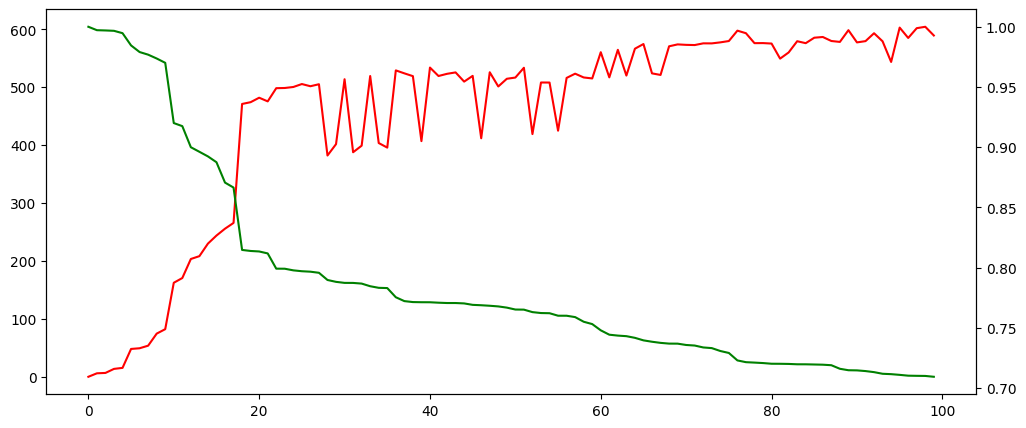

In [24]:
plt.figure(figsize=(12, 5))

plt.plot(df_match_tab.index, df_match_tab['diff'], c='r', label='diff')
ax2 = plt.gca().twinx()
ax2.plot(df_match_tab.index, df_match_tab['cos_sim'], c='g', label='cos_sim')
plt.plot()

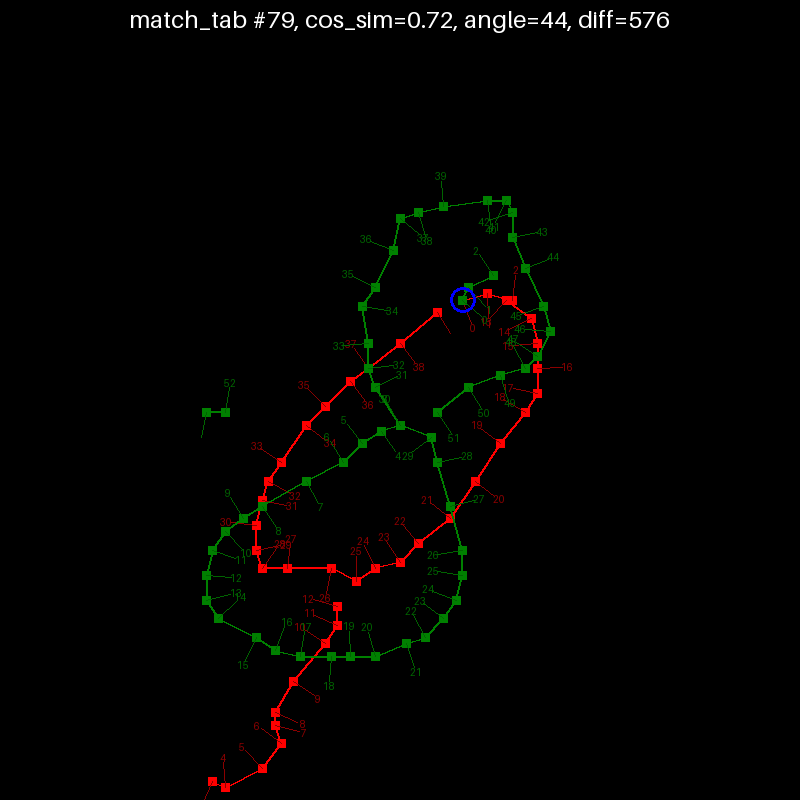

In [25]:
image_pil = Image.new('L', size=(800, 800), color='black')
image_pil = image_pil.convert('RGB')
k = image_pil.size[0] / config.sample_size
draw = ImageDraw.Draw(image_pil)

match_tab_row_index = RNG.choice(len(df_match_tab))
df_match_tab_row = df_match_tab.iloc[match_tab_row_index]

matchee_seq_lv_ind = df_match_tab_row['matchee_seq_lv_ind']
matchee_seq = matchee.seqs[matchee_seq_lv_ind]
matchee_xy_seq = get_xy_sequence(matchee_seq, matchee.si_ind_dict)
matchee_pt_xy = matchee_xy_seq[0]

engram = ENGRAMS[df_match_tab_row['engram_id']]
engram_seq_lv_ind = df_match_tab_row['engram_seq_lv_ind']
engram_seq_lv_meta = SEQ_LV_IND_TO_META[engram_seq_lv_ind]
engram_seq = engram_seq_lv_meta.seq
engram_xy_seq = get_xy_sequence(engram_seq, engram.si_ind_dict)

assert engram_seq.shape[0] == engram_xy_seq.shape[0]

engram_xy_seq = engram_xy_seq - engram_xy_seq[0] + matchee_pt_xy
engram_si_serial_to_xy = {}

for si_serial, (xy_seq_row, seq_row) in enumerate(zip(zip(engram_xy_seq, engram_xy_seq[1:]), zip(engram_seq, engram_seq[1:]))):
    pt_from = xy_seq_row[0][0], xy_seq_row[0][1] 
    pt_to = xy_seq_row[1][0], xy_seq_row[1][1]
    
    vec = pt_to[0] - pt_from[0], pt_to[1] - pt_from[1]

    if np.linalg.norm(vec) < 10:
        draw.line([k * pt_from[0], k * pt_from[1], k * pt_to[0], k * pt_to[1]], width=2, fill='red')
        
    draw.rectangle([k * pt_from[0] - 4, k * pt_from[1] - 4, k * pt_from[0] + 4, k * pt_from[1] + 4], width=1, fill='red')
    draw.rectangle([k * pt_to[0] - 4, k * pt_to[1] - 4, k * pt_to[0] + 4, k * pt_to[1] + 4], width=1, fill='red')

    si_from = engram.si_ind_dict[seq_row[0]]
    si_to = engram.si_ind_dict[seq_row[1]]
    nl = 4 * k
    normal_vec = si_from.normal_vec
    draw.line([k * pt_from[0], k * pt_from[1], k * pt_from[0] + normal_vec.real * nl, k * pt_from[1] + normal_vec.imag * nl], width=1, fill='darkred')
    draw.text([k * pt_from[0] + normal_vec.real * nl*1.2, k * pt_from[1] + normal_vec.imag * nl*1.2], str(si_serial), anchor='mm', fill='darkred')

    normal_vec = si_to.normal_vec
    draw.line([k * pt_to[0], k * pt_to[1], k * pt_to[0] + normal_vec.real * nl, k * pt_to[1] + normal_vec.imag * nl], width=1, fill='darkred')
    # draw.text([pt_to[0] + normal_vec.real * nl*1.2, pt_to[1] + normal_vec.imag * nl*1.2], str(si_ind_to), anchor='mm', fill='red')
    
    engram_si_serial_to_xy[si_serial] = (k * pt_from[0], k * pt_from[1])
    engram_si_serial_to_xy[si_serial + 1] = (k * pt_to[0], k * pt_to[1])

matchee_si_serial_to_xy = {}

for si_serial, (xy_seq_row, seq_row) in enumerate(zip(zip(matchee_xy_seq, matchee_xy_seq[1:]), zip(matchee_seq, matchee_seq[1:]))):
    pt_from = xy_seq_row[0][0], xy_seq_row[0][1] 
    pt_to = xy_seq_row[1][0], xy_seq_row[1][1]
    vec = pt_to[0] - pt_from[0], pt_to[1] - pt_from[1]
    # color = 'red' if np.linalg.norm(vec) < 10 else 'gray'

    if np.linalg.norm(vec) < 10:
        draw.line([k * pt_from[0], k * pt_from[1], k * pt_to[0], k * pt_to[1]], width=2, fill='green')
        
    draw.rectangle([k * pt_from[0] - 4, k * pt_from[1] - 4, k * pt_from[0] + 4, k * pt_from[1] + 4], width=1, fill='green')
    draw.rectangle([k * pt_to[0] - 4, k * pt_to[1] - 4, k * pt_to[0] + 4, k * pt_to[1] + 4], width=1, fill='green')

    si_from = matchee.si_ind_dict[seq_row[0]]
    si_to = matchee.si_ind_dict[seq_row[1]]
    nl = 4 * k
    normal_vec = si_from.normal_vec
    draw.line([k * pt_from[0], k * pt_from[1], k * pt_from[0] + normal_vec.real * nl, k * pt_from[1] + normal_vec.imag * nl], width=1, fill='darkgreen')
    draw.text([k * pt_from[0] + normal_vec.real * nl*1.2, k * pt_from[1] + normal_vec.imag * nl*1.2], str(si_serial), anchor='mm', fill='darkgreen')

    normal_vec = si_to.normal_vec
    draw.line([k * pt_to[0], k * pt_to[1], k * pt_to[0] + normal_vec.real * nl, k * pt_to[1] + normal_vec.imag * nl], width=1, fill='darkgreen')
    # draw.text([pt_to[0] + normal_vec.real * nl*1.2, pt_to[1] + normal_vec.imag * nl*1.2], str(si_ind_to), anchor='mm', fill='red')
    
    matchee_si_serial_to_xy[si_serial] = (k * pt_from[0], k * pt_from[1])
    matchee_si_serial_to_xy[si_serial + 1] = (k * pt_to[0], k * pt_to[1])

draw.circle((k * matchee_pt_xy[0], k * matchee_pt_xy[1]), radius=k*2, outline='blue', width=3)

draw.text((image_pil.size[0] / 2, 10), f'match_tab #{match_tab_row_index}, cos_sim={df_match_tab_row['cos_sim']:.2f}, angle={np.rad2deg(np.arccos(df_match_tab_row['cos_sim'])):.0f}, diff={df_match_tab_row['diff']:.0f}', font_size=24, anchor='mt')
image_pil

# Test

In [30]:
%%time
test_results_db_con.cursor().execute('INSERT INTO test_runs(dummy) VALUES(1)')
test_run_id = test_results_db_con.cursor().execute('SELECT MAX(test_run_id) FROM test_runs').fetchone()[0]
test_run_source = {
    'test': (df_test_images, test_db_con, 'test'),
    'train': (df_train_images, train_db_con, 'train')
}['test']
count = min(200, len(test_run_source[0]))
test_image_ids = RNG.choice(test_run_source[0].index.unique(), count, replace=False)
test_image_ids = [100004526]
# test_image_ids = image_ids
test_result_rows = defaultdict(list)
match_tabs = []

for image_id in tqdm(test_image_ids):
    df_image = test_run_source[0].loc[image_id]
    image_value = df_image['value']
    matchee = create_matchee(df_image)
    # df_match_tab = get_match_tab(matchee, compute_diff=False)
    df_match_tab = get_match_tab(matchee)
    df_match_tab['test_image_id'] = image_id
    df_match_tab['true_value'] = image_value
    match_tabs.append(df_match_tab)
    
    infer_value, engram_image_id, cos_sim = ('', -1, 0)
        
    if len(df_match_tab) > 0:
        infer_value, engram_image_id, cos_sim = df_match_tab.iloc[0][['engram_value', 'engram_image_id', 'cos_sim']]
    
    test_result_rows['test_run_id'].append(test_run_id)
    test_result_rows['config_variant'].append(config.section_name)
    test_result_rows['cortical_columns'].append(f'[{','.join([])}]')
    test_result_rows['train_images_count'].append(TRAIN_IMAGES_COUNT)
    test_result_rows['train_runs_count'].append(TRAIN_RUNS_COUNT)
    test_result_rows['source_ds'].append(test_run_source[2])
    test_result_rows['test_image_id'].append(image_id)
    test_result_rows['true_value'].append(image_value)
    test_result_rows['engram_image_id'].append(engram_image_id)
    test_result_rows['infer_value'].append(infer_value)
    test_result_rows['cos_sim'].append(cos_sim)
    test_result_rows['match_tab_index'].append(len(match_tabs) - 1)


df_test_results_for_run = pd.DataFrame(test_result_rows)
DBUtils.ensure_table_columns(test_results_db_con, 'test_results', list(df_test_results_for_run.columns))
df_test_results_for_run.to_sql(name='test_results', con=test_results_db_con, if_exists='append')
pd.DataFrame({'test_run_id': [test_run_id], 'match_tabs': [pickle.dumps(match_tabs)]}).to_sql(name='test_run_artifacts', con=test_results_db_con, if_exists='append');

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 1.42 s, sys: 3.73 ms, total: 1.43 s
Wall time: 202 ms


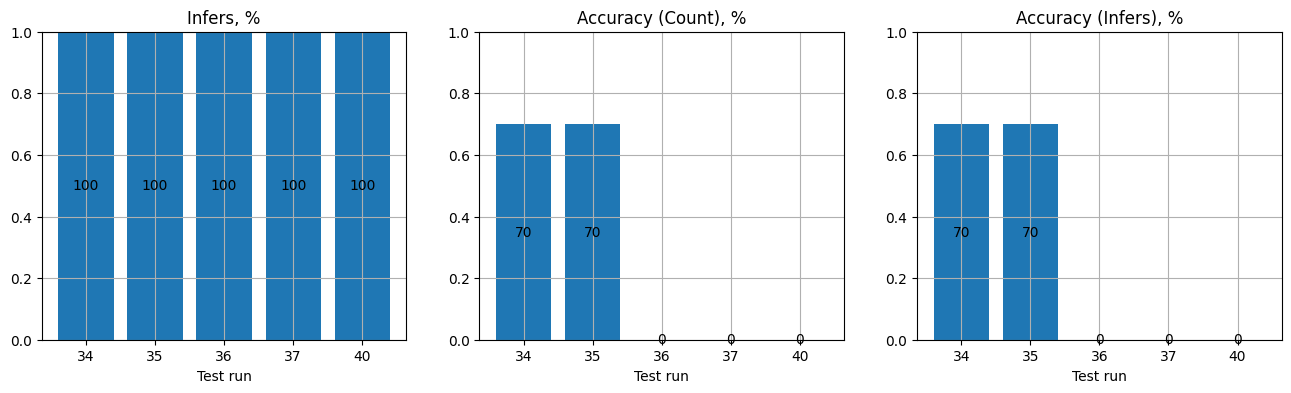

,config_variant,source_ds,cortical_columns,train_images_count,train_runs_count,count,infers,correct_infers,infer_ratio,accuracy_count,accuracy_infers
test_run_id,,,,,,,,,,,
34,SQLITE3_SEQ_GRID_0_2_4096,test,[],100,1,20,20,14,1.0,0.7,0.7
35,SQLITE3_SEQ_GRID_0_2_4096,test,[],100,1,20,20,14,1.0,0.7,0.7
36,SQLITE3_SEQ_GRID_0_2_4096,test,[],100,1,1,1,0,1.0,0.0,0.0
37,SQLITE3_SEQ_GRID_0_2_4096,test,[],100,1,1,1,0,1.0,0.0,0.0
40,SQLITE3_SEQ_GRID_0_2_4096,test,[],100,1,1,1,0,1.0,0.0,0.0


In [31]:
df_test_results2 = pd.read_sql_query('''
SELECT * FROM test_results 
WHERE test_run_id IN (SELECT test_run_id FROM test_runs ORDER BY test_run_id DESC LIMIT 10)
ORDER BY test_run_id ASC
''', con=test_results_db_con)
df_test_results2['is_infer'] = df_test_results2['infer_value'] != ''
df_test_results2['is_correct_infer'] = df_test_results2['true_value'] == df_test_results2['infer_value']
df_test_results2 = df_test_results2.groupby(by=['test_run_id']).agg({'config_variant': 'first', 
                                                                     'source_ds': 'first',
                                                                     'cortical_columns': 'first',
                                                                     'train_images_count': 'first',
                                                                     'train_runs_count': 'first',
                                                                     'test_image_id': 'count', 
                                                                     'is_infer': 'sum', 
                                                                     'is_correct_infer': 'sum'})
df_test_results2.rename(columns=dict(test_image_id='count', is_infer='infers', is_correct_infer='correct_infers'), inplace=True, errors='raise')
df_test_results2['infer_ratio'] = df_test_results2['infers'] / df_test_results2['count']
df_test_results2['accuracy_count'] = df_test_results2['correct_infers'] / df_test_results2['count']
df_test_results2['accuracy_infers'] = df_test_results2['correct_infers'] / df_test_results2['infers']
df_test_results2['accuracy_infers'] = df_test_results2['accuracy_infers'].fillna(0)

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['infer_ratio']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['infer_ratio']), label_type='center')
plt.ylim(0, 1)
plt.title('Infers, %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 2)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_count']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_count']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Count), %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 3)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_infers']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_infers']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Infers), %')
plt.xlabel('Test run')
plt.grid()

plt.show()
df_test_results2

## analyze

In [32]:
df_incorrect = df_test_results_for_run.loc[df_test_results_for_run.true_value != df_test_results_for_run.infer_value]
df_incorrect[['test_image_id', 'true_value', 'engram_image_id', 'infer_value', 'cos_sim', 'match_tab_index']]

,test_image_id,true_value,engram_image_id,infer_value,cos_sim,match_tab_index
0,100004526,3,20448,2,0.822179,0


In [33]:
df_correct = df_test_results_for_run.loc[df_test_results_for_run.true_value == df_test_results_for_run.infer_value]
df_correct[['test_image_id', 'true_value', 'engram_image_id', 'infer_value', 'cos_sim', 'match_tab_index']]

,test_image_id,true_value,engram_image_id,infer_value,cos_sim,match_tab_index


In [34]:
match_tab_index = 0
# match_tabs[match_tab_index].sort_values(by=['cos_sim'], inplace=True)
match_tabs[match_tab_index].head(20)

,engram_seq_lv_ind,matchee_seq_lv_ind,cos_sim,diff,engram_id,engram_value,engram_image_id,engram_phase,matchee_seq_lv_code,test_image_id,true_value
0,412,150,0.822179,-1,14,2,20448,0,"((1, 0), (2, 1), (3, 1), (0, 0))",100004526,3
1,412,161,0.821130,-1,14,2,20448,0,"((1, 0), (3, 0), (0, 0), (2, 1))",100004526,3
2,426,268,0.820784,-1,14,2,20448,584,"((2, 1), (3, 1), (0, 0), (1, 0))",100004526,3
3,435,36,0.820356,-1,14,2,20448,986,"((0, 0), (2, 1), (1, 0), (3, 0))",100004526,3
4,434,297,0.819415,-1,14,2,20448,950,"((3, 1), (0, 0), (1, 0), (2, 1))",100004526,3
5,1824,150,0.819407,-1,49,8,15636,272,"((1, 0), (2, 1), (3, 1), (0, 0))",100004526,3
6,435,37,0.818976,-1,14,2,20448,986,"((0, 0), (2, 1), (1, 0), (3, 1))",100004526,3
7,414,165,0.818839,-1,14,2,20448,50,"((1, 0), (3, 1), (0, 0), (2, 1))",100004526,3
8,413,161,0.818651,-1,14,2,20448,18,"((1, 0), (3, 0), (0, 0), (2, 1))",100004526,3
9,1545,35,0.818312,-1,41,3,7966,1242,"((0, 0), (2, 0), (1, 1), (3, 1))",100004526,3


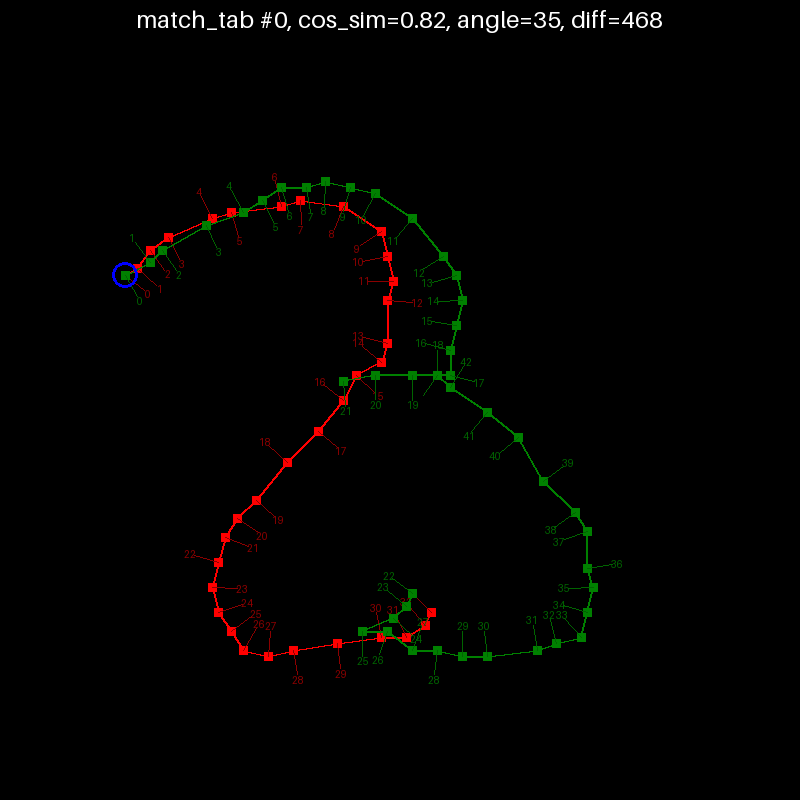

In [35]:
df_match_tab_row = match_tabs[match_tab_index].iloc[0]
test_image_id = df_match_tab_row['test_image_id']

if test_image_id >= 100_000_000:
    df_test_image = df_test_images.loc[test_image_id]
else:
    df_test_image = df_train_images.loc[test_image_id]

# matchee = create_matchee(df_test_image, df_match_tab_row['matchee_seq_lv_code'])
matchee = create_matchee(df_test_image)
render_match_tab_row(df_match_tab_row, matchee)

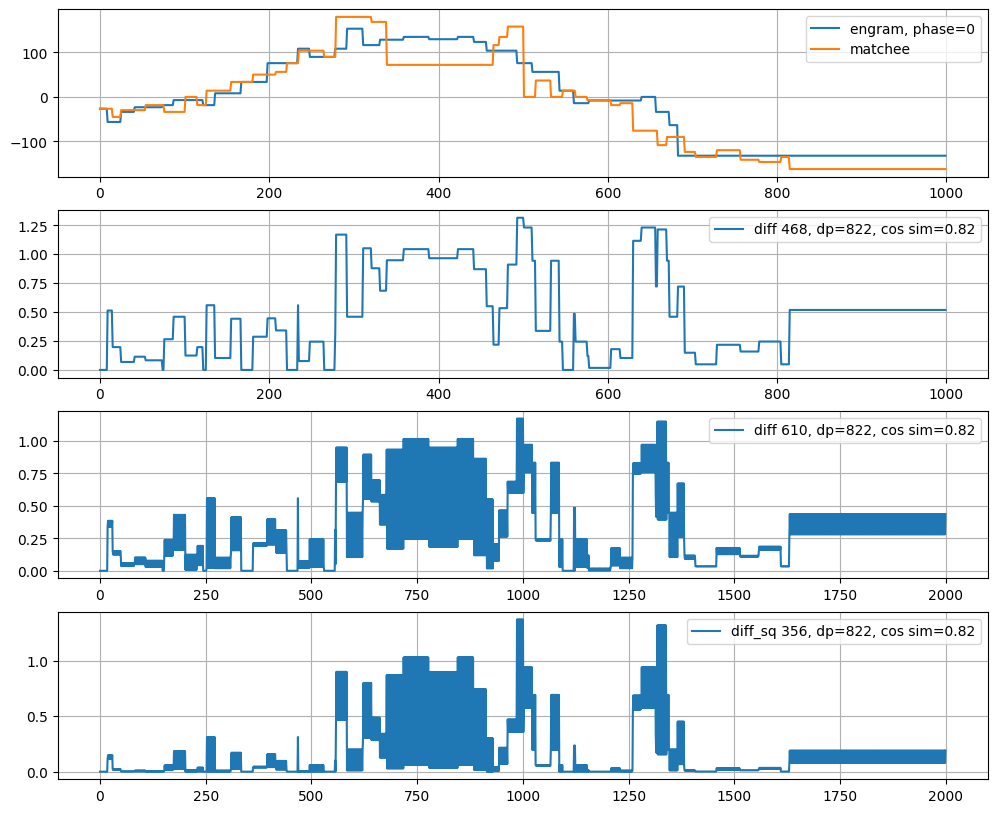

In [39]:
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)

engram_seq_lv_ind = df_match_tab_row['engram_seq_lv_ind']
engram_seq_lv = SEQ_LVS.array_active[df_match_tab_row['engram_seq_lv_ind']]
engram_seq_lv_j = engram_seq_lv.reshape(-1, 2)
engram_seq_lv_j = engram_seq_lv_j[:,0] + 1j * engram_seq_lv_j[:,1]
plt.plot(np.angle(engram_seq_lv_j, deg=True), label=f'engram, phase={SEQ_LV_IND_TO_META[engram_seq_lv_ind].phase}')

matchee_seq_lv_code = df_match_tab_row['matchee_seq_lv_code']
matchee_seq_lv_ind = matchee.seq_lv_codes.index(matchee_seq_lv_code)
matchee_seq_lv = matchee.seq_lvs[matchee_seq_lv_ind]
matchee_seq_lv_j = matchee_seq_lv.reshape(-1, 2)
matchee_seq_lv_j = matchee_seq_lv_j[:,0] + 1j * matchee_seq_lv_j[:,1]
plt.plot(np.angle(matchee_seq_lv_j, deg=True), label=f'matchee')

plt.grid()
plt.legend()

dp = engram_seq_lv @ matchee_seq_lv
cos_sim = dp / SEQ_LV_LEN

plt.subplot(4, 1, 2)
diff = np.sum(np.absolute(engram_seq_lv_j - matchee_seq_lv_j))
plt.plot(np.absolute(engram_seq_lv_j - matchee_seq_lv_j), label=f'diff {diff:.0f}, dp={dp:0.0f}, cos sim={cos_sim:.2f}')
plt.grid()
plt.legend()

plt.subplot(4, 1, 3)
diff = np.sum(np.absolute(engram_seq_lv - matchee_seq_lv))
plt.plot(np.absolute(engram_seq_lv - matchee_seq_lv), label=f'diff {diff:.0f}, dp={dp:0.0f}, cos sim={cos_sim:.2f}')
plt.grid()
plt.legend()

plt.subplot(4, 1, 4)
diff_sq = np.sum((engram_seq_lv - matchee_seq_lv) ** 2)
plt.plot((engram_seq_lv - matchee_seq_lv) ** 2, label=f'diff_sq {r_sq:.0f}, dp={dp:0.0f}, cos sim={cos_sim:.2f}')
plt.grid()
plt.legend()


plt.show()

In [ ]:
engram_seq_lv[50:70]

In [ ]:
matchee_seq_lv[50:70]

In [ ]:
cos_sims = []

for vec_len in range(1, SEQ_LV_LEN + 1):
    dp = engram_seq_lv[:vec_len*2] @ matchee_seq_lv[:vec_len*2]
    cos_sim = dp / vec_len
    cos_sims.append(cos_sim)

plt.plot(list(range(SEQ_LV_LEN)), cos_sims)
plt.show()

In [ ]:
engram_seq_lv.mean()

In [ ]:
v1 = engram_seq_lv - engram_seq_lv.mean()
v2 = matchee_seq_lv - matchee_seq_lv.mean()

In [ ]:
v1 @ v2 / v1.shape, np.sqrt(v1 @ v2 / v1.shape)

In [ ]:
v1.shape

In [ ]:
np.linalg.norm(engram_seq_lv)